In [1]:
import os

import matplotlib
import matplotlib.pyplot as plt

from jax.experimental.ode import build_odeint, odeint
import jax.numpy as np
from jax.random import PRNGKey
import numpy as onp

import numpyro
import numpyro.distributions as dist
# from numpyro.examples.datasets import LYNXHARE, load_dataset
from numpyro.infer import MCMC, NUTS, Predictive
import arviz as az

NUM_CHAINS = 1
numpyro.set_host_device_count(NUM_CHAINS)
numpyro.enable_x64()

# Data

In [8]:
import pandas as pd

ix = pd.IndexSlice

full = pd.read_csv('full.csv', index_col=['location', 'date', 'variable'], parse_dates=['date']).iloc[:, 0]
populations_country = pd.read_csv('populations_country.csv', index_col='location').iloc[:, 0]

country = 'France'
subset = full.loc[country]
deaths_subset = subset.loc[ix[:, 'total_deaths']]

pop_country = populations_country.loc[country]

ten_deaths_date = deaths_subset.gt(10).cumsum().loc[lambda s: s==1].index[0]
begin_date = ten_deaths_date - pd.Timedelta(30, unit='days')

total_deaths = deaths_subset.loc[begin_date:].values
# data = total_deaths / pop_country

times = deaths_subset.loc[begin_date:].index.map(onp.datetime64).to_numpy()

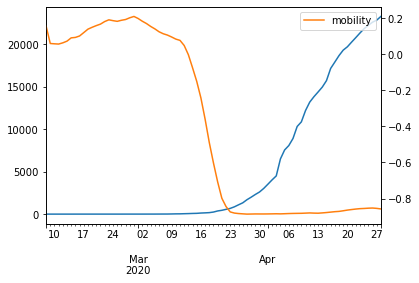

In [9]:
mobility = subset.loc[ix[:, 'transit']].rename('mobility')
mobility = mobility.reindex(deaths_subset.loc[begin_date:].index).fillna(mobility.iloc[-1]).rolling('7d').mean()

to_plot = pd.DataFrame({'deaths': total_deaths}, index=times).join(mobility)
to_plot['deaths'].plot(label='deaths')
to_plot['mobility'].plot(secondary_y=True)
plt.legend() ;

## France data
This data is rich, because we have the number of hospitalized and critical.

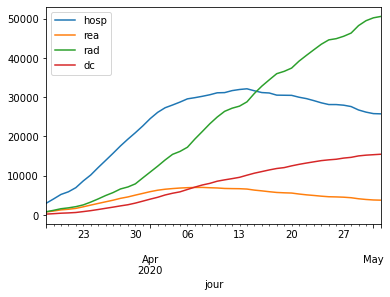

In [10]:
hosp = pd.read_csv('donnees-hospitalieres-covid19-2020-05-02-19h00.csv', sep=';', parse_dates=['jour']).loc[lambda f: f['sexe'] == 0].groupby('jour').sum().drop('sexe', axis=1)
hosp.plot() ;

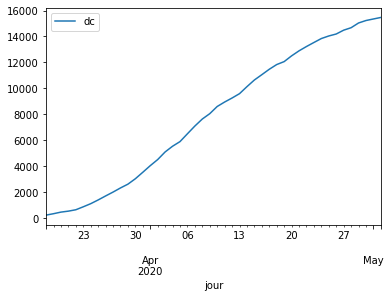

In [11]:
hosp.dc.plot()
plt.legend() ;

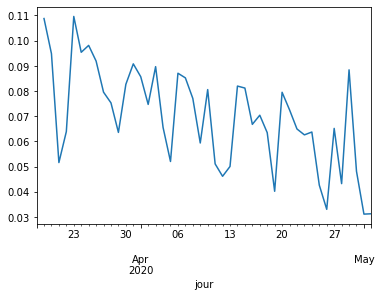

In [12]:
hosp.eval('dc.diff() / rea').plot() ;

In [18]:
hosp_indexed = hosp.reindex(times).fillna(0)
hosp_indexed

,hosp,rea,rad,dc
jour,,,,
2020-02-08,0.0,0.0,0.0,0.0
2020-02-09,0.0,0.0,0.0,0.0
2020-02-10,0.0,0.0,0.0,0.0
2020-02-11,0.0,0.0,0.0,0.0
2020-02-12,0.0,0.0,0.0,0.0
...,...,...,...,...
2020-04-24,28554.0,4785.0,43486.0,13841.0
2020-04-25,28119.0,4641.0,44587.0,14039.0
2020-04-26,28114.0,4598.0,44896.0,14191.0


# SEIR-HCD

## Prior choice

We use France's Covid data, that includes the number of critical, deceased, hospitalized (and recovered).

## Parameters used in the model

R_t = reproduction number at time t. Typical 3.6* at t=0

Transition times

    T_inc = average incubation period. Typical 5.6* days
    T_inf = average infectious period. Typical 2.9 days
    T_hosp = average time a patient is in hospital before either recovering or becoming critical. Typical 4 days
    T_crit = average time a patient is in a critical state (either recover or die). Typical 14 days

Fractions  
These constants are likely to be age specific (hence the subscript a):

    m_a = fraction of infections that are asymptomatic or mild. Assumed 80% (i.e. 20% severe)
    c_a = fraction of severe cases that turn critical. Assumed 10%
    f_a = fraction of critical cases that are fatal. Assumed 30%
    
*Averages taken from https://www.kaggle.com/covid-19-contributions

## Equations

In [19]:
%%latex
\begin{align}
\frac{dS}{dt} &= - \frac{R_t}{T_{inf}} I S \\
\frac{dE}{dt} &= \frac{R_t}{T_{inf}} I S - \frac{E}{T_{inc}} \\
\frac{dI}{dt} &= \frac{E}{T_{inc}} - \frac{I}{T_{inf}} \\
\frac{dR}{dt} &= m_a \frac{I}{T_{inf}} + (1 - c_a)\frac{H}{T_{hosp}} \\
\frac{dH}{dt} &= (1 - m_a) \frac{I}{T_{inf}} + (1 - f_a)\frac{C}{T_{crit}} - \frac{H}{T_{hosp}} \\
\frac{dC}{dt} &= c_a \frac{H}{T_{hosp}} - \frac{C}{T_{crit}} \\
\frac{dD}{dt} &= f_a \frac{C}{T_{crit}}
\end{align}

<IPython.core.display.Latex object>

## Implementation

In [20]:
mobility_data = np.asarray(mobility.to_numpy())

def dz_dt(z, t, r0, r1, t_inc, t_inf, t_hosp, t_crit, m_a, c_a, f_a):
    s = z[0]
    e = z[1]
    i = z[2]
    r = z[3]
    h = z[4]
    c = z[5]

    int_t = np.array([t]).astype(int)[0]
    rt = r0 * (1 + mobility_data[int_t]) - r1 * mobility_data[int_t]
    
    ds = - (rt / t_inf) * i * s
    de = (rt / t_inf) * i * s - (e / t_inc)
    di = e / t_inc - i / t_inf
    dr = m_a * i / t_inf + (1 - c_a) * (h / t_hosp)
    dh = (1 - m_a) * (i / t_inf) + (1 - f_a) * c / t_crit - h / t_hosp
    dc = c_a * h / t_hosp - c / t_crit
    dd = f_a * c / t_crit
    
    return np.stack([ds, de, di, dr, dh, dc, dd])

seirhcd_int = build_odeint(dz_dt, rtol=1e-5, atol=1e-9, mxstep=500)

In [23]:
def reparametrize_beta(u, v):
#     v = numpyro.sample(f'sample_size_{i}', dist.Exponential(1.))
    return u*v, (1-u)*v

def reparametrize_gamma(mean, std):
    var = std ** 2
    alpha = mean ** 2 / var
    beta = mean / var
    return alpha, beta

def model(N, y=None, compartments='d'):
    i_init = numpyro.sample('i_init', dist.Gamma(*reparametrize_gamma(100, 50.))) / pop_country
    z_init = np.array([1. - i_init, 0., i_init, 0., 0., 0., 0.])
    ts = np.arange(float(N))
    
    kappa0 = numpyro.sample('kappa0', dist.TruncatedNormal(0, 0., 0.5))
    kappa1 = numpyro.sample('kappa1', dist.TruncatedNormal(0, 0, 0.5))
    r0 = numpyro.sample('r0', dist.TruncatedNormal(0, 3.28, kappa0))
    r1 = numpyro.sample('r1', dist.TruncatedNormal(0., 0.7, kappa1))
    
#     t_delta = numpyro.sample('t_delta', dist.Gamma(*reparametrize_gamma(3., 1.)))
#     t_delta = int(np.floor(t_delta))
    
    t_inc = numpyro.sample('t_inc', dist.Gamma(*reparametrize_gamma(5.6, .86)))
    t_inf = numpyro.sample('t_inf', dist.Gamma(*reparametrize_gamma(2.9, 1.)))
    t_hosp = numpyro.sample('t_hosp', dist.Gamma(*reparametrize_gamma(4., 1.)))
    t_crit = numpyro.sample('t_crit', dist.Gamma(*reparametrize_gamma(14., 1.)))
    
    sample_size = numpyro.sample('sample_size', dist.Exponential(1.0))
    m_a = numpyro.sample('m_a', dist.Beta(*reparametrize_beta(0.8, sample_size)))
    c_a = numpyro.sample('c_a', dist.Beta(*reparametrize_beta(0.1, sample_size)))
    f_a = numpyro.sample('f_a', dist.Beta(*reparametrize_beta(0.35, sample_size)))
    
    params = (r0, r1, t_inc, t_inf, t_hosp, t_crit, m_a, c_a, f_a)
    
    z = seirhcd_int(z_init, ts, *params)
    
    total_deaths = z[:, -1]
    daily_deaths = np.hstack((np.array([0.]), np.diff(total_deaths * pop_country))) + 1

    psi = numpyro.sample('psi', dist.TruncatedNormal(scale=5.))
    
    if compartments == 'd':
        numpyro.sample('y', dist.GammaPoisson(psi * daily_deaths, rate=psi), obs=y)
    
    elif compartments == 'hcd':
        psi_h = numpyro.sample('psi_h', dist.TruncatedNormal(scale=5.))
        psi_c = numpyro.sample('psi_c', dist.TruncatedNormal(scale=5.))
        numpyro.sample('y', dist.GammaPoisson(
            np.stack([psi_h * (z[:, -3]*pop_country + 1), 
                      psi_c * (z[:, -2]*pop_country + 1), 
                      psi * daily_deaths]).T,
            rate=np.array([psi_h, psi_c, psi])),
                       obs=y)

In [24]:
# For France data
daily_deaths = np.hstack((np.array([0.]), np.diff(hosp_indexed['dc'].to_numpy())))
data = np.stack([hosp_indexed['hosp'].to_numpy(), hosp_indexed['rea'].to_numpy(), daily_deaths]).T
data.shape

(81, 3)

In [65]:
# use dense_mass for better mixing rate
mcmc = MCMC(NUTS(model, dense_mass=True),
            200, 200, num_chains=NUM_CHAINS,
            progress_bar=True)
mcmc.run(PRNGKey(0), N=data.shape[0], y=daily_deaths, compartments='d')
mcmc.print_summary()

sample: 100%|██████████| 400/400 [05:24<00:00,  1.23it/s, 555 steps of size 3.15e-01. acc. prob=0.89]  



                   mean       std    median      5.0%     95.0%     n_eff     r_hat
          c_a      0.10      0.15      0.04      0.00      0.27     24.63      1.00
          f_a      0.49      0.27      0.47      0.12      1.00     53.13      1.02
       i_init     45.98     10.64     46.52     24.52     60.02    198.38      1.00
       kappa0      0.56      0.36      0.52      0.03      1.07     77.98      1.00
       kappa1      0.50      0.29      0.46      0.07      0.92     90.57      1.01
          m_a      0.91      0.13      0.97      0.73      1.00     15.80      1.03
          psi      0.02      0.00      0.02      0.01      0.03    227.70      1.00
           r0      3.94      0.56      3.89      3.11      4.62    101.57      1.00
           r1      1.06      0.77      0.80      0.05      2.10    127.79      1.02
  sample_size      1.88      1.20      1.51      0.29      3.77     68.92      1.01
       t_crit     13.99      0.98     13.96     12.33     15.50    207.95  

In [135]:
y_pred = Predictive(model, mcmc.get_samples())(PRNGKey(2), data.shape[0])['y']

pop_pred = y_pred
mu = np.mean(pop_pred, 0)
pi = np.percentile(pop_pred.astype(float), (10., 90.), 0)

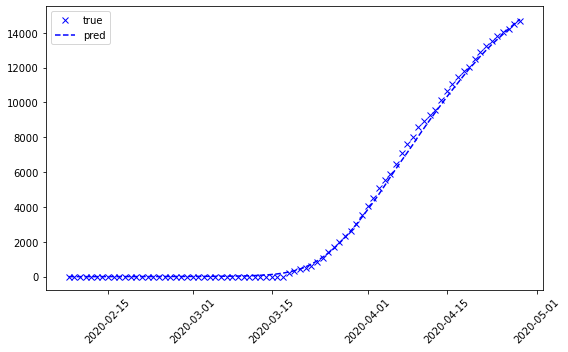

In [176]:
fig, ax = plt.subplots(figsize=(8, 5))

plt.plot(times, np.cumsum(daily_deaths), "bx", label="true")
plt.plot(times, np.cumsum(mu), "b--", label="pred")
plt.legend()
plt.xticks(rotation=45)

plt.tight_layout()

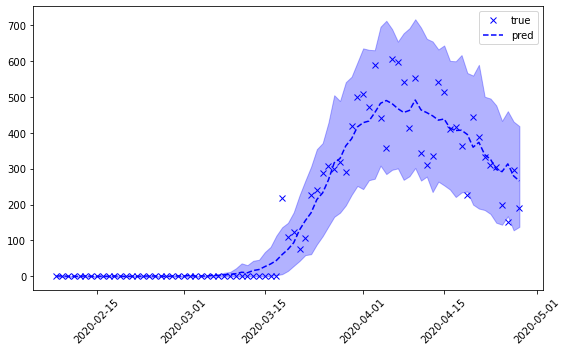

In [137]:
fig, ax = plt.subplots(figsize=(8, 5))

plt.plot(times, daily_deaths, "bx", label="true")
plt.plot(times, mu, "b--", label="pred")
plt.fill_between(times, pi[0, :], pi[1, :], color="b", alpha=0.3)
plt.legend()
plt.xticks(rotation=45)

plt.tight_layout()

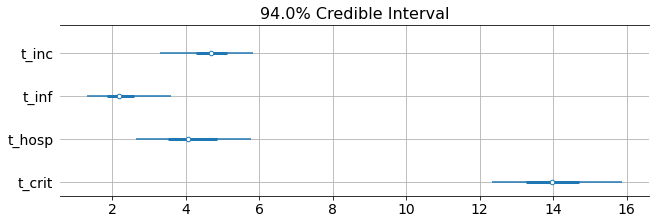

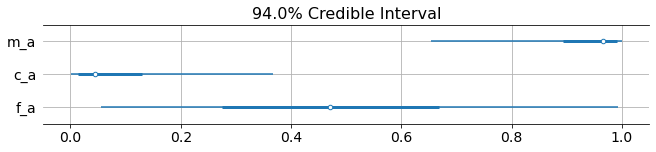

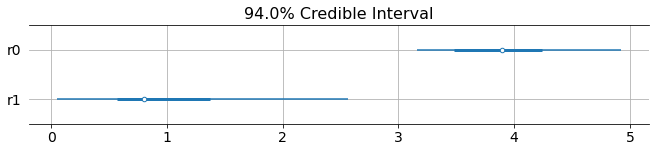

In [138]:
inference_data = az.from_numpyro(mcmc)

az.plot_forest(inference_data, var_names=['t_inc', 't_inf', 't_hosp', 't_crit'], kind='forestplot', ridgeplot_overlap=3, combined=True, figsize=(9, 3))
plt.grid()
az.plot_forest(inference_data, var_names=['m_a', 'c_a', 'f_a'], figsize=(9, 2))
plt.grid()
az.plot_forest(inference_data, var_names=['r0', 'r1'], figsize=(9, 2))
plt.grid()
# az.plot_forest(inference_data, var_names=['t_lim'], figsize=(9, 1))

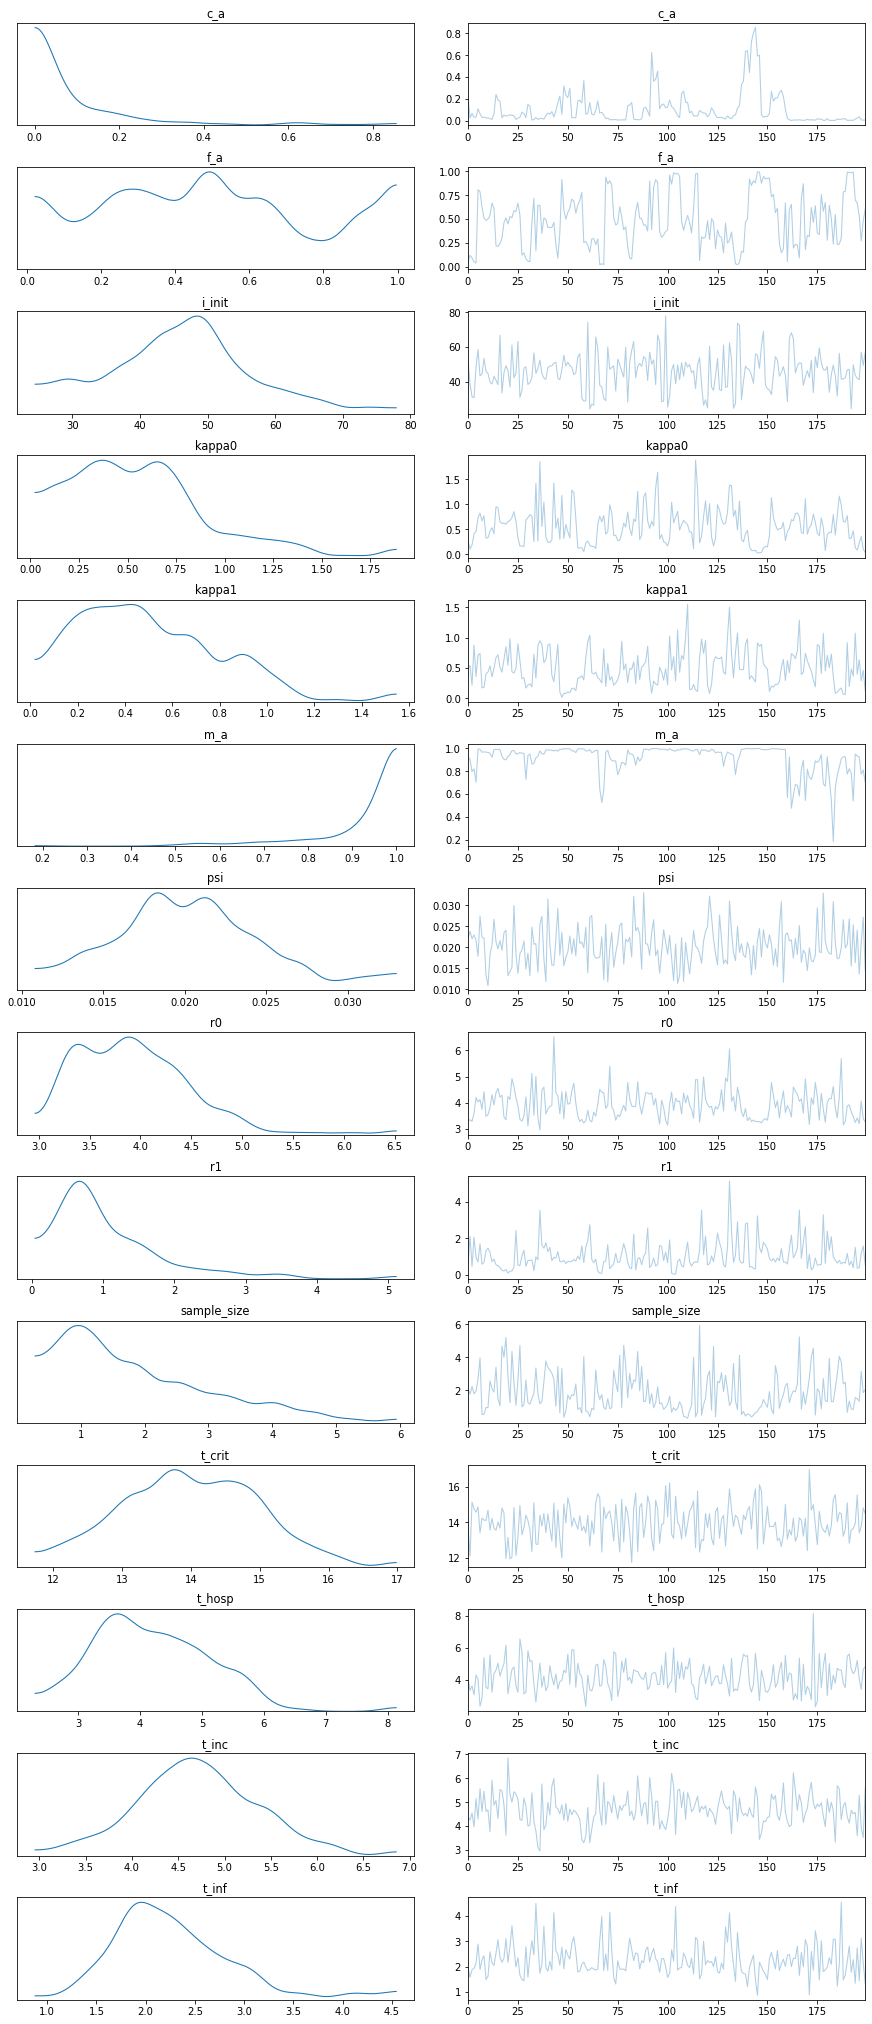

In [139]:
az.plot_trace(inference_data) ;

## Running the compartment model

In [153]:
samples = mcmc.get_samples()
# pred = Predictive(model, mcmc.get_samples())(PRNGKey(2), data.shape[0])

In [140]:
post_params = dict()
for param in 'r0, r1, t_inc, t_inf, t_hosp, t_crit, m_a, c_a, f_a'.split(', '):
#     post_params[param] = samples[param][100:].mean()
    post_params[param] = inference_data.posterior[param].values[0, -1]

# i_init = samples['i_init'][100:].mean()
i_init = inference_data.posterior[param].values[0, -1]
i_init /= pop_country

In [154]:
def run_sim_samples(mobility_data, samples):
    def dz_dt(z, t, r0, r1, t_inc, t_inf, t_hosp, t_crit, m_a, c_a, f_a):
        s = z[0]
        e = z[1]
        i = z[2]
        r = z[3]
        h = z[4]
        c = z[5]

        int_t = np.array([t]).astype(int)[0]
        rt = r0 * (1 + mobility_data[int_t]) - r1 * mobility_data[int_t]

        ds = - (rt / t_inf) * i * s
        de = (rt / t_inf) * i * s - (e / t_inc)
        di = e / t_inc - i / t_inf
        dr = m_a * i / t_inf + (1 - c_a) * (h / t_hosp)
        dh = (1 - m_a) * (i / t_inf) + (1 - f_a) * c / t_crit - h / t_hosp
        dc = c_a * h / t_hosp - c / t_crit
        dd = f_a * c / t_crit

        return np.stack([ds, de, di, dr, dh, dc, dd])


    ts = np.arange(float(data.shape[0]))
    seirhcd_int_2 = build_odeint(dz_dt, rtol=1e-5, atol=1e-9, mxstep=500)
    res = []
    for i in range(100):
        post_params = dict()
        for param in 'r0, r1, t_inc, t_inf, t_hosp, t_crit, m_a, c_a, f_a'.split(', '):
            post_params[param] = samples[param][100+i]
    #         post_params[param] = inference_data.posterior[param].values[0, -1]

        i_init = samples['i_init'][100+i]
        i_init /= pop_country
        z_init = np.array([1. - i_init, 0., i_init, 0., 0., 0., 0.])
        args = post_params.values()
        sim_res = seirhcd_int_2(z_init, ts, *args)
        res.append(sim_res)

    res = np.stack(res)
    return res

In [164]:
def plot_compartment(pred_data, true_data):
    pi = np.percentile(pred_data, (10., 90.), 0)
    
    plt.plot(times, np.mean(pred_data, axis=0) * pop_country, label='pred')
    plt.plot(times, true_data, label='true')
    plt.fill_between(times, pi[0, :] * pop_country, pi[1, :] * pop_country, interpolate=True, alpha=0.3)
    plt.legend()

In [169]:
def plot_hcd(res, hosp_indexed):
    plot_compartment(res[:, :, -1], hosp_indexed['dc'].to_numpy())
    plt.title('deaths')

    plt.subplots()

    plot_compartment(res[:, :, -2], hosp_indexed['rea'].to_numpy())
    plt.title('critical')

    plt.subplots()
    plot_compartment(res[:, :, -3], hosp_indexed['hosp'].to_numpy())
    plt.title('hospitalized')


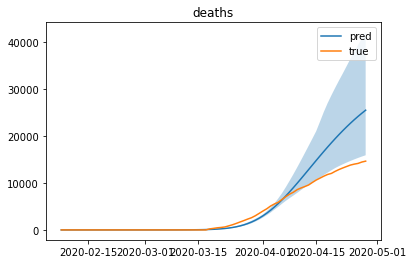

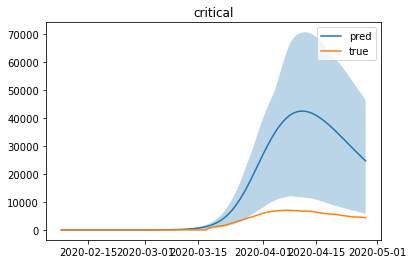

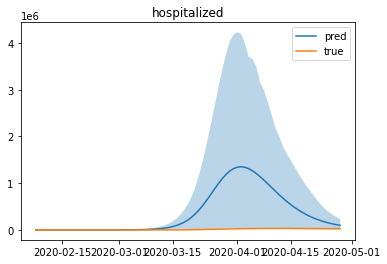

In [171]:
mobility_data = np.zeros(ts.shape[0])
res_fake = run_sim_samples(mobility_data, samples)

plot_hcd(res_fake, hosp_indexed)

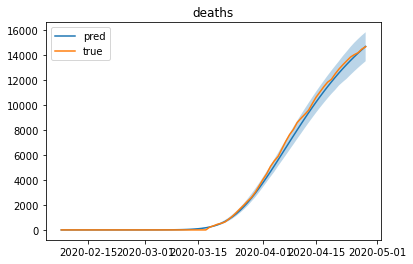

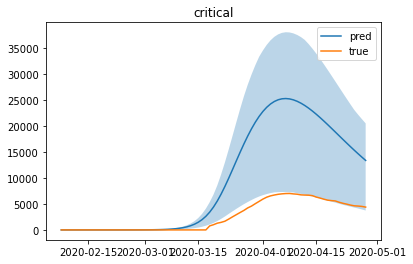

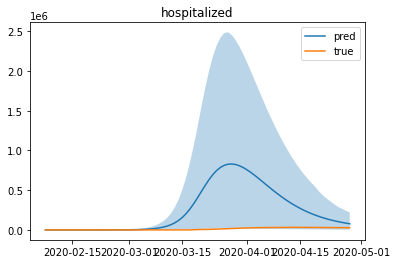

In [172]:
mobility_data = np.asarray(mobility.to_numpy())
res = run_sim_samples(mobility_data, samples)

plot_hcd(res, hosp_indexed)

## When res only contains one series per compartment

In [91]:
df_res = pd.DataFrame(res) * pop_country
df_res.columns = 's e i r h c d'.split()

fig, ax = plt.subplots()
df_res = df_res.eval('total_cases = i + r + h + c + d').set_index(times)
df_res['d'].plot(figsize=(8, 5), ax=ax)
total_deaths_indexed = pd.DataFrame({'true': total_deaths}).set_index(times)
total_deaths_indexed.plot(ax=ax)
plt.legend() ;

fig, ax = plt.subplots()
df_res['total_cases'].plot()
subset.loc[ix[:, 'total_cases']].plot(ax=ax, secondary_y=True)

# Misc

In [100]:
daily_deaths = np.array([0, 0, 1, 2, 3, 5]) + 1

for i in range(100):
    with numpyro.handlers.seed(rng_seed=i):
        psi = numpyro.sample('psi', dist.TruncatedNormal(scale=5.))
#         print(f'{psi=}')
        gp_sample = numpyro.sample('y', dist.GammaPoisson(psi * daily_deaths, rate=psi))
#         print(gp_sample)
        beta_sample = numpyro.sample('m_a', dist.Beta(*reparametrize_beta(0.8, numpyro.sample('sample_size', dist.Exponential(1.0)))))
#         print(beta_sample)

# SI model
Inspired by the predator-prey tutorial and the PYMC3 ode blog post

We use first a SI model, of two populations:
- Susceptible (S)
- Infected (I)

The dynamics of populations is governed by a system of differential equations:
- $\frac{dS}{dt} = - R_0 S I$
- $\frac{dI}{dt} = R_0 S I$